<a href="https://colab.research.google.com/github/rodmart21/Sports_analytics/blob/main/Progressive_Passes_Expected_Threat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculate Expected Threat based on Progressive Passes.

These are some articles that explore this concept of expected threat:
- https://karun.in/blog/expected-threat.html#visualizing-xt
- https://soccermatics.medium.com/explaining-expected-threat-cbc775d97935a
- https://theathletic.com/2751525/2021/08/06/introducing-expected-threat-or-xt-the-new-metric-on-the-block/
- https://sharmaabhishekk.github.io/projects/xt-derivation-julia (if you are interested in the Julia language)
- https://www.youtube.com/watch?v=RwVLUH4BFfA

## 1) Data Preparation

This dataset is from the Europa League Final between Manchester United and Villarreal. It is taken from the John McKay github: https://github.com/mckayjohns/youtube-videos/blob/main/data/europaFinal.csv

In [1]:
pip install mplsoccer  # This library is designed for graphic football representations.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 1.4 MB/s eta 0:00:00


In [2]:
# Import all necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

In [20]:
df = pd.read_csv('/content/europaFinal.csv')

In [21]:
df.head(2)

,minute,second,teamId,x,y,period,type,outcome,playerId,endX,endY
0,0,0.0,Manchester United,0.0,0.0,FirstHalf,Start,Successful,NaN,NaN,NaN
1,0,0.0,Villarreal,0.0,0.0,FirstHalf,Start,Successful,NaN,NaN,NaN


In [22]:
df.shape

(2071, 11)

A graphic representation of the passes can be created. To make everything clearer, we will only represent those made by Villarreal and in one half so it is possible to compare with one goal.

In [24]:
df_P = df.loc[(df['teamId'] == 'Villarreal') & (df['type'] == 'Pass') & (df['period'] == 'FirstHalf') & (df['outcome'] == 'Successful')]
df_P.shape

(113, 11)

In [25]:
df_P.head(2)

,minute,second,teamId,x,y,period,type,outcome,playerId,endX,endY
4,0,32.0,Villarreal,34.4,0.0,FirstHalf,Pass,Successful,8.0,36.5,9.5
5,0,34.0,Villarreal,35.1,9.1,FirstHalf,Pass,Successful,7.0,31.9,2.3


In [26]:
df_P['y'].describe()

count    113.000000
mean      45.726549
std       33.027459
min        0.000000
25%       12.200000
50%       40.300000
75%       73.200000
max      100.000000
Name: y, dtype: float64

  There are some outliers in our data, as you can see above the maximum value of y is 172, this doen't make any sense, there is no field such big. Making a representation it is clearer, no one can give a pass from the crowd.

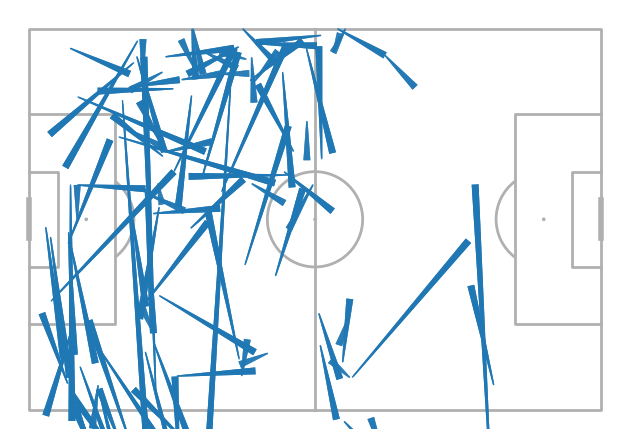

In [27]:
pitch = Pitch(pitch_type='statsbomb')
fig,ax = pitch.draw()
pitch.lines(df_P.x,df_P.y,df_P.endX,df_P.endY,comet=True,ax=ax)

This means that there are some outliers in our data that should be eliminated.

In [28]:
df_P_filtered = df_P[(df_P['x'] <= 120) & (df_P['y'] <= 80) & (df_P['endX'] <= 120) & (df_P['endY'] <= 80)]

In [29]:
df_P_filtered.shape

(78, 11)

Now all the passes are inside the limits of the field represented.

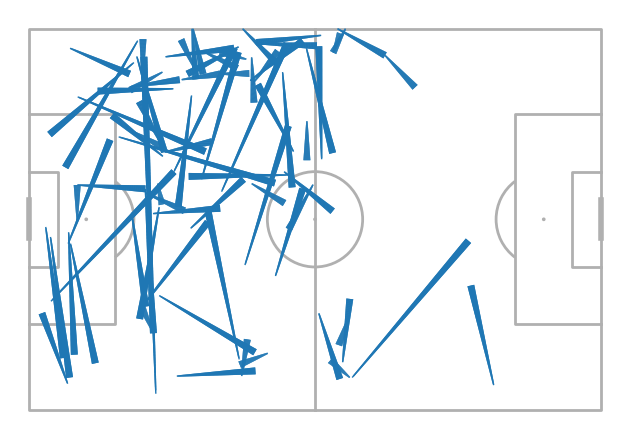

In [30]:
pitch = Pitch(pitch_type='statsbomb')
fig,ax = pitch.draw()
pitch.lines(df_P_filtered.x,df_P_filtered.y,df_P_filtered.endX,df_P_filtered.endY,comet=True,ax=ax)

## 2) Analyze the progressive passes.

### 2.1) Calculate progressive passes.

Calculate the distance to the rival goal, that is located in x=120 and y=40. Depending on the avanced

In [31]:
df_P_filtered['beginning'] = np.sqrt(np.square(120 - df_P_filtered['x']) + np.square(40 - df_P_filtered['y']))
df_P_filtered['end'] = np.sqrt(np.square(120 - df_P_filtered['endX']) + np.square(40 - df_P_filtered['endY']))#df_P['progressive'] = [(df_P['end'][x]) / (df_P['beginning'][x]) < .75 for x in range(len(df_P.beginning))]
df_P_filtered['progressive'] = (df_P_filtered['end'] / df_P_filtered['beginning']) < .75

<ipython-input-31-ce1f39d5563e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P_filtered['beginning'] = np.sqrt(np.square(120 - df_P_filtered['x']) + np.square(40 - df_P_filtered['y']))
<ipython-input-31-ce1f39d5563e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P_filtered['end'] = np.sqrt(np.square(120 - df_P_filtered['endX']) + np.square(40 - df_P_filtered['endY']))#df_P['progressive'] = [(df_P['end'][x]) / (df_P['beginning'][x]) < .75 for x in range(len(df_P.beginning))]
<ipython-input-31-ce

In [32]:
df_progressive=df_P_filtered[(df_P_filtered['progressive']==True) & (df_P_filtered['outcome']=='Successful')]

Representation of these passses considered as progressive

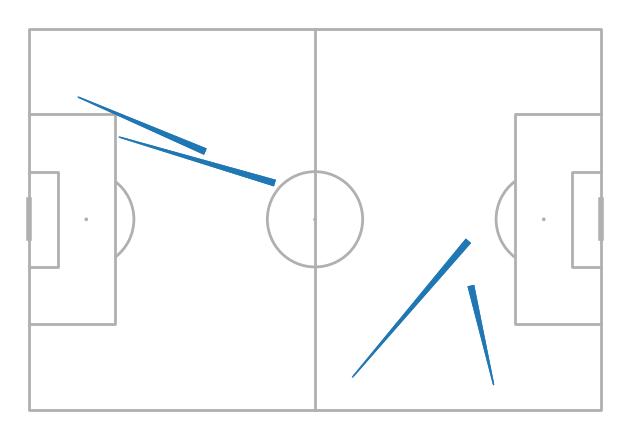

In [33]:
pitch = Pitch(pitch_type='statsbomb')
fig,ax = pitch.draw()
pitch.lines(df_progressive.x,df_progressive.y,df_progressive.endX,df_progressive.endY,comet=True,ax=ax)

### 2.2) Analyze the expected threat (xT).

Now, depending on the zone where the progressive passes have occured, the expected thread will be different.

In this blog, another type of variable is analyzed. It reproduces those passes that are not assists but generate a dangerous opportunity for the team: https://karun.in/blog/expected-threat.html


In [ ]:
df.head(2)

,minute,second,teamId,x,y,period,type,outcome,playerId,endX,endY
2,0,0.0,Manchester United,49.9,50.0,FirstHalf,Pass,Successful,18.0,31.5,59.6
119,6,11.0,Manchester United,65.4,96.8,FirstHalf,Pass,Successful,18.0,63.3,87.8


We load this grid where the field is divided into stripes with their respective expected danger values in each case.

In [36]:
xT= pd.read_csv('/content/xT_Grid.csv', header=None)
xT=np.array(xT)
xT_rows, xT_cols= xT.shape
xT

array([[0.00638303, 0.00779616, 0.00844854, 0.00977659, 0.01126267,
        0.01248344, 0.01473596, 0.0174506 , 0.02122129, 0.02756312,
        0.03485072, 0.0379259 ],
       [0.00750072, 0.00878589, 0.00942382, 0.0105949 , 0.01214719,
        0.0138454 , 0.01611813, 0.01870347, 0.02401521, 0.02953272,
        0.04066992, 0.04647721],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138, 0.06442595],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138,

Taking the dataframe containing all passes made by Villarreal players, each pass is represented in one of the various rectangles that divide the field. Each pass has its own rectangle, defined by the initial and final positions.

In [37]:
df_P_filtered['x1_bin']=pd.cut(df_P_filtered['x'], bins=xT_cols, labels=False)
df_P_filtered['y1_bin']=pd.cut(df_P_filtered['y'], bins=xT_rows, labels=False)
df_P_filtered['x2_bin']=pd.cut(df_P_filtered['endX'], bins=xT_cols, labels=False)
df_P_filtered['y2_bin']=pd.cut(df_P_filtered['endY'], bins=xT_rows, labels=False)

<ipython-input-37-7da042ae5029>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P_filtered['x1_bin']=pd.cut(df_P_filtered['x'], bins=xT_cols, labels=False)
<ipython-input-37-7da042ae5029>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P_filtered['y1_bin']=pd.cut(df_P_filtered['y'], bins=xT_rows, labels=False)
<ipython-input-37-7da042ae5029>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [38]:
df_P_filtered.head(3)

,minute,second,teamId,x,y,period,type,outcome,playerId,endX,endY,beginning,end,progressive,x1_bin,y1_bin,x2_bin,y2_bin
4,0,32.0,Villarreal,34.4,0.0,FirstHalf,Pass,Successful,8.0,36.5,9.5,94.484708,88.896007,False,3,0,4,0
5,0,34.0,Villarreal,35.1,9.1,FirstHalf,Pass,Successful,7.0,31.9,2.3,90.348326,95.827449,False,4,0,3,0
8,0,52.0,Villarreal,34.2,0.0,FirstHalf,Pass,Successful,8.0,35.0,10.6,94.665939,89.940869,False,3,0,4,1


Make the correspondence between each bin and the expected threat they are assigned. The final value of expected threat is determined by the diference between the initial and final value.

In [41]:
df_P_filtered['start_zone_value']= df_P_filtered[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]],axis=1)
df_P_filtered['end_zone_value']= df_P_filtered[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]],axis=1)
df_P_filtered['xT']=df_P_filtered['end_zone_value']-df_P_filtered['start_zone_value']

<ipython-input-41-d13653d163f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P_filtered['start_zone_value']= df_P_filtered[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]],axis=1)
<ipython-input-41-d13653d163f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P_filtered['end_zone_value']= df_P_filtered[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]],axis=1)
<ipython-input-41-d13653d163f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [42]:
df_P_filtered.head()

,minute,second,teamId,x,y,period,type,outcome,playerId,endX,...,beginning,end,progressive,x1_bin,y1_bin,x2_bin,y2_bin,start_zone_value,end_zone_value,xT
4,0,32.0,Villarreal,34.4,0.0,FirstHalf,Pass,Successful,8.0,36.5,...,94.484708,88.896007,False,3,0,4,0,0.009777,0.011263,0.001486
5,0,34.0,Villarreal,35.1,9.1,FirstHalf,Pass,Successful,7.0,31.9,...,90.348326,95.827449,False,4,0,3,0,0.011263,0.009777,-0.001486
8,0,52.0,Villarreal,34.2,0.0,FirstHalf,Pass,Successful,8.0,35.0,...,94.665939,89.940869,False,3,0,4,1,0.009777,0.012147,0.002371
9,0,54.0,Villarreal,34.1,14.0,FirstHalf,Pass,Successful,5.0,31.3,...,89.748593,88.738098,False,3,1,3,4,0.010595,0.011324,0.000729
14,1,14.0,Villarreal,26.6,76.6,FirstHalf,Pass,Successful,4.0,24.1,...,100.315104,101.782218,False,2,7,2,0,0.008449,0.008449,0.000000


### 3) Validation

Logically, the passes that we have labeled as progressive will have a higher expected threat than those that haven't. There is a high correlation between these two values.

In [52]:
df_P_filtered_corr = df_P_filtered[['progressive', 'xT']]

In [53]:
correlation_matrix = df_P_filtered_corr.corr()
print(correlation_matrix)

             progressive        xT
progressive     1.000000  0.558488
xT              0.558488  1.000000


In [44]:
df_P_filtered[df_P_filtered['progressive']==True]

,minute,second,teamId,x,y,period,type,outcome,playerId,endX,...,beginning,end,progressive,x1_bin,y1_bin,x2_bin,y2_bin,start_zone_value,end_zone_value,xT
265,18,4.0,Villarreal,10.2,14.3,FirstHalf,Pass,Successful,25.0,37.0,...,112.767593,84.205938,True,0,1,4,2,0.007501,0.012692,0.005191
333,22,30.0,Villarreal,97.5,74.8,FirstHalf,Pass,Successful,9.0,92.7,...,41.440198,30.634947,True,11,7,11,5,0.037926,0.064426,0.026500
432,28,52.0,Villarreal,67.8,73.2,FirstHalf,Pass,Successful,5.0,92.2,...,61.863398,28.161854,True,8,7,11,4,0.021221,0.257454,0.236232
446,30,38.0,Villarreal,18.8,22.7,FirstHalf,Pass,Successful,3.0,51.6,...,102.668057,68.820927,True,1,2,6,3,0.009777,0.016895,0.007118


In fact, the pass with the highest xT is one that we have considered as progressive.

In [54]:
df_P_filtered.xT.describe()

count    78.000000
mean      0.004553
std       0.026902
min      -0.004967
25%      -0.000300
50%       0.001138
75%       0.002512
max       0.236232
Name: xT, dtype: float64

Other validation methods can be applied to check this progressive passes and expected threat assigned to them.